In [1]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
RELATIVE_PATH="SpamData/01_Processing/practice_email.txt"
SPAM_1_PATH="SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH="SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH="SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH="SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"
DATA_JSON_FILE_PATH="SpamData/01_Processing/email-data.json"
WHALE_FILE="SpamData/01_Processing/wordcloud_resources/whale-icon.png"
SKULL_FILE="SpamData/01_Processing/wordcloud_resources/skull-icon.png"
THUMBS_UP_FILE="SpamData/01_Processing/wordcloud_resources/thumbs-up.png"
THUMBS_DOWN_FILE="SpamData/01_Processing/wordcloud_resources/thumbs-down.png"
CUSTOM_FONT_FILE="SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf"
WORD_ID_FILE="SpamData/01_Processing/word_id.csv"
TRAINING_DATA_FILE="SpamData/02_Training/train_data.txt"
TEST_DATA_FILE="SpamData/02_Training/test_data.txt"
VOCAB_SIZE=2500
SPAM_CAT=1
HAM_CAT=0
is_body=False
lines=[]
with open(RELATIVE_PATH,"r",encoding="latin-1") as file:
    for line in file:
        if is_body:
            lines.append(line)
        if line=="\n":
            is_body=True
email_body="\n".join(lines).replace("\n\n\n","\n")
print(email_body.replace("\n\n","\n")[1:])

Dear Mr Still
Good tidings to you and all your staff for the festive season ahead (Christmas).
Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.
But WAIT! You're probably thinking: "What makes him so special?"
Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.
You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.
I look forward to hearing from you.
Best wishes
Robin Cooper
[Excerpt from the book: The Timewaster Letters by Robin C

# Generator Function

In [3]:
def email_body_generator(path):
    for root,dirnames,filename in walk(path):
        for file_name in filename:
            filepath=join(root,file_name)
            is_body=False
            lines=[]
            with open(filepath,"r",encoding="latin-1") as file:
                for line in file:
                    if is_body:
                        lines.append(line)
                    if line=="\n":
                        is_body=True
            email_body="\n".join(lines)
            yield file_name,email_body

In [4]:
def df_from_directory(path,classification):
    rows=[]
    rows_name=[]
    for file,email_body in email_body_generator(path):
        rows.append({"MESSAGE":email_body,"CATEGORY":classification})
        rows_name.append(file)
    # print(len(rows))
    return pd.DataFrame(rows,index=rows_name)


In [5]:
spam_email=df_from_directory(SPAM_1_PATH,1)
# spam_email=spam_email.append(df_from_directory(SPAM_2_PATH,1))
spam_email=pd.concat((spam_email,df_from_directory(SPAM_2_PATH,1)),axis=0)
spam_email.shape

(1898, 2)

In [6]:
spam_email.shape

(1898, 2)

In [7]:
ham_email=df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
print(ham_email.shape)
ham_email=pd.concat((ham_email,df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT)),axis=0)
ham_email.shape

(2501, 2)


(3901, 2)

In [8]:
data=pd.concat([spam_email,ham_email])
print(data.shape)
data.head()

(5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [9]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning

In [10]:
data.MESSAGE.isnull().values.any()

False

In [11]:
(data.MESSAGE.str.len()==0).any()

True

In [12]:
data[(data.MESSAGE.str.len()==0)].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [13]:
data.drop(["cmds"],inplace=True)

In [14]:
data[(data.MESSAGE.str.len()==0)].index

Index([], dtype='object')

In [15]:
data.shape

(5796, 2)

### Adding Document id

In [16]:
document_id=range(0,len(data.index))
data["DOC_ID"]=document_id
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [17]:
data["FILE_NAME"]=data.index
data=data.set_index("DOC_ID")
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [18]:
data.to_json(DATA_JSON_FILE_PATH)

## Pie Chart

In [19]:
amount_of_spam=data.CATEGORY.value_counts()[1]
amount_of_ham=data.CATEGORY.value_counts()[0]

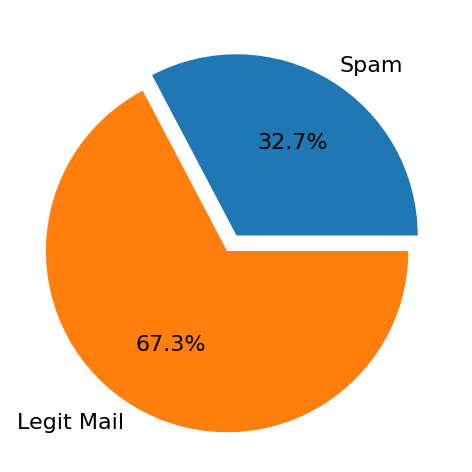

In [20]:
category_names=["Spam","Legit Mail"]
sizes=[amount_of_spam,amount_of_ham]
plt.figure(figsize=(10,6),dpi=100)
plt.pie(sizes,labels=category_names,textprops={"fontsize":16},autopct="%1.1f%%",explode=[0,0.1])
plt.style.use(style="dark_background")
plt.show()

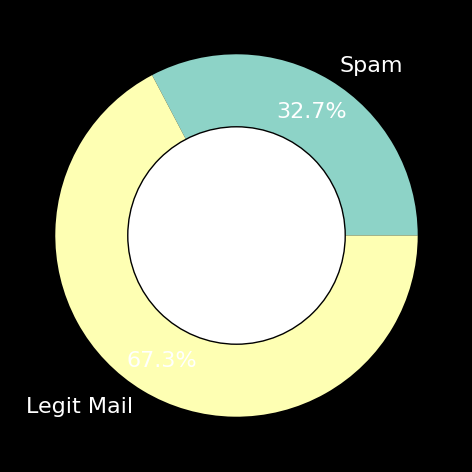

In [21]:
category_names=["Spam","Legit Mail"]
sizes=[amount_of_spam,amount_of_ham]
plt.figure(figsize=(10,6),dpi=100)
plt.pie(sizes,labels=category_names,textprops={"fontsize":16},autopct="%1.1f%%",pctdistance=0.8)
plt.style.use(style="classic")
centre_circle=plt.Circle((0,0),radius=0.6,fc="white")
plt.gca().add_artist(centre_circle)
plt.show()

## Natural Language Processing

### Text Pre-Processing

In [22]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
soup=BeautifulSoup(data.at[2,"MESSAGE"],"html.parser")
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [25]:
soup.getText()
set(stopwords.words("english"))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [26]:
# stop_word=stopwords.words("english")
def clean_message(message,stemmer=PorterStemmer(),stop_word=set(stopwords.words("english"))):
    words=word_tokenize(message.lower())
    filtered_word=[]
    for word in words:
        if word not in stop_word and word.isalpha():
            filtered_word.append(stemmer.stem(word))
    return filtered_word

In [27]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [28]:
# stop_word=stopwords.words("english")
def clean_msg_no_html(message,stemmer=PorterStemmer(),stop_word=set(stopwords.words("english"))):
    soup=BeautifulSoup(message,"html.parser")
    message=soup.getText()
    words=word_tokenize(message.lower())
    filtered_word=[]
    for word in words:
        if word not in stop_word and word.isalpha():
            filtered_word.append(stemmer.stem(word))
    return filtered_word

In [29]:
clean_message(data.at[2,"MESSAGE"])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

In [30]:
# first_emails=data.MESSAGE.iloc[0:3]
# nested_list=first_emails.apply(clean_message)

In [31]:
# flat_list=[item for sublist in nested_list for item in sublist]
# len(flat_list)

In [32]:
nested_list=data.MESSAGE.apply(clean_msg_no_html)

c:\Users\Shubham\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Users\Shubham\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [33]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [34]:
doc_id_spam=data[data.CATEGORY==1].index
doc_id_ham=data[data.CATEGORY==0].index
doc_id_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [35]:
nested_list_ham=nested_list.loc[doc_id_ham]
nested_list_spam=nested_list.loc[doc_id_spam]
# nested_list_ham.shape
nested_list_spam

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, Length: 1896, dtype: object

In [36]:
# sum([len(sublist) for sublist in nested_list_ham])
flat_list_ham=[item for sublist in nested_list_ham for item in sublist]
normal_word=pd.Series(flat_list_ham).value_counts()
normal_word.shape[0]

20815

In [37]:
# sum([len(sublist) for sublist in nested_list_spam])
normal_word[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [38]:
flat_list_spam=[item for sublist in nested_list_spam for item in sublist]
spam_word=pd.Series(flat_list_spam).value_counts()
spam_word.shape[0]

13242

In [39]:
spam_word[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

## Creating Word Cloud

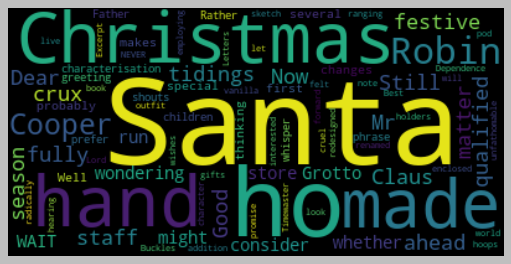

In [40]:
word_cloud=WordCloud().generate(email_body)
plt.axis("off")
plt.imshow(word_cloud,interpolation="bilinear")

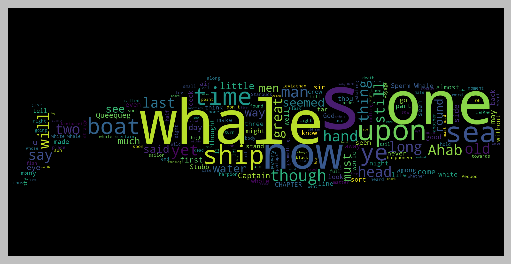

In [41]:
example_corpus=nltk.corpus.gutenberg.words("melville-moby_dick.txt")
word_list=[''.join(word) for word in example_corpus]
novel_as_string=' '.join(word_list)
icon=Image.open(WHALE_FILE)
image_mask=Image.new(mode="RGB",size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)
word_cloud=WordCloud(mask=rgb_array,max_words=200).generate(novel_as_string)
plt.axis("off")
plt.imshow(word_cloud)

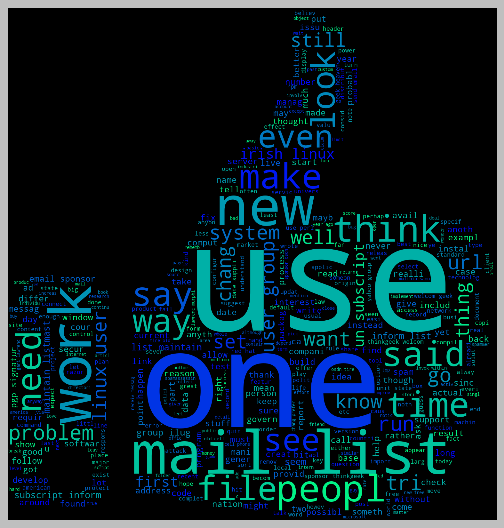

In [42]:
word_list=[''.join(word) for word in flat_list_ham]
novel_as_string=' '.join(word_list)
icon=Image.open(THUMBS_UP_FILE)
image_mask=Image.new(mode="RGB",size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)
word_cloud=WordCloud(mask=rgb_array,max_words=400,colormap="winter").generate(novel_as_string)
plt.figure(figsize=[16,8])
plt.axis("off")
plt.imshow(word_cloud)

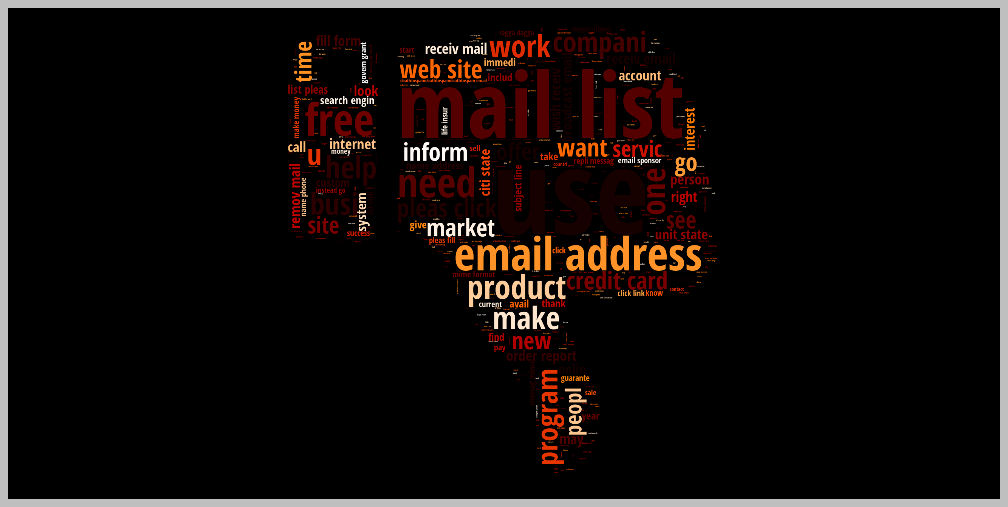

In [43]:
word_list=[word for word in flat_list_spam]
novel_as_string=' '.join(word_list)
icon=Image.open(THUMBS_DOWN_FILE)
image_mask=Image.new(mode="RGB",size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array=np.array(image_mask)
word_cloud=WordCloud(mask=rgb_array,max_words=500,colormap="gist_heat",font_path=CUSTOM_FONT_FILE).generate(novel_as_string)
plt.figure(figsize=[16,8])
plt.axis("off")
plt.imshow(word_cloud)

## Generate Vocabulary 

In [44]:
nested_stemmed_word=data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list=[word for sublist in nested_stemmed_word for word in sublist]

c:\Users\Shubham\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\Users\Shubham\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [45]:
unique_words=pd.Series(flat_stemmed_list).value_counts()
print("Number of unique words: ",unique_words.shape[0])
unique_words.head().index

Number of unique words:  27334


Index(['http', 'use', 'list', 'email', 'get'], dtype='object')

In [46]:
# frequent_word=[word for word in unique_words.head(2500).index]
# frequent_word[:10]
frequent_word=unique_words[0:VOCAB_SIZE]
frequent_word

http        10660
use          5019
list         4851
email        4367
get          4200
            ...  
bob            44
occasion       43
bullet         43
steven         43
analog         43
Length: 2500, dtype: int64

In [47]:
word_ids=list(range(0,VOCAB_SIZE))
vocab=pd.DataFrame({"VOCAB_WORD":frequent_word.index.values},index=word_ids)
vocab.index.name="WORD_ID"
vocab

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get
...,...
2495,bob
2496,occasion
2497,bullet


In [48]:
vocab.to_csv(WORD_ID_FILE,index_label=vocab.index.name,header=vocab.VOCAB_WORD.name)

In [49]:
the_word=["machine","learning","fun","learn","data","science","app","brewer"]
for word in the_word:
    if word in set(vocab.VOCAB_WORD):  #vocab.VOCAB_WORD.values:
        print(f"{word}:True")
    else:
        print(f"{word}:False")


machine:False
learning:False
fun:True
learn:True
data:True
science:False
app:True
brewer:False


In [51]:
nested_stemmed_word
md=pd.DataFrame(nested_stemmed_word)
# print(max([len(sublist) for sublist in nested_stemmed_word]))
# md[max([len(sublist) for sublist in md.MESSAGE])==7671].index.value
length=[len(sublist) for sublist in md.MESSAGE]
# md["Length"]=length
# ln=md[max(md.Length)==md.Length].index.values[0]
# md[md.index.values[0]==ln].MESSAGE
# md.iloc[ln]
# ln
# md.tail(30)
print(max(length))
print(np.argmax(length))
nested_stemmed_word[np.argmax(length)]

7671
5775


['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [ ]:
word_column_df=pd.DataFrame.from_records(nested_stemmed_word.tolist())
word_column_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
word_column_df.shape

(5796, 7671)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(word_column_df,data.CATEGORY,test_size=0.3,random_state=42)

In [52]:
X_train.shape

NameError: name 'X_train' is not defined

In [ ]:
X_train.index.name=X_test.index.name="DOC_ID"
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### Sparse matrix for the trainig model


In [ ]:
word_index=pd.Index(vocab.VOCAB_WORD)
# word_index.get_loc("thu")
# word_index
# type(word_index)

pandas.core.indexes.base.Index

In [ ]:
def make_sparse_matrix(df,indexed_words,labels):
    nr_rows=df.shape[0]
    nr_columns=df.shape[1]
    word_set=set(indexed_words)
    dict_list=[]
    for i in range(nr_rows):
        for j in range(nr_columns):
            word=df.iat[i,j]
            if word in word_set:
                doc_id=df.index[i]
                word_id=indexed_words.get_loc(word)
                category=labels.at[doc_id]
                item={"LABEL":category,"DOC_ID":doc_id,"OCCURENCE":1,"WORD_ID":word_id}
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [ ]:
sparse_train_df=make_sparse_matrix(X_train,word_index,y_train)
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1243
2,0,4844,1,502
3,0,4844,1,308
4,0,4844,1,254


## Combine Occurencce using groupby()

In [ ]:
train_grouped=sparse_train_df.groupby(["DOC_ID","WORD_ID","LABEL"]).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [ ]:
vocab.at[0,"VOCAB_WORD"]

'http'

In [ ]:
train_grouped=train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [ ]:
train_grouped.shape

(258360, 4)

## saving train data as txt file

In [ ]:
np.savetxt(TRAINING_DATA_FILE,train_grouped,fmt="%d")

In [ ]:
sparse_test_df=make_sparse_matrix(X_test,word_index,y_test)

In [ ]:
test_grouped=sparse_test_df.groupby(["DOC_ID","WORD_ID","LABEL"]).sum()
test_grouped=test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [ ]:
np.savetxt(TEST_DATA_FILE,test_grouped,fmt="%d")

In [ ]:
# train_grouped.DOC_ID.value_counts()
train_docs_id=set(train_grouped.DOC_ID)
test_docs_id=set(test_grouped.DOC_ID)

In [ ]:
print(len(train_docs_id))
print(len(test_docs_id))

4013
1724


In [ ]:
len(X_test)

1739

In [ ]:
set(X_test.index.values)-test_docs_id

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [ ]:
data.MESSAGE[179]

'------=_NextPart_000_00A5_78C83A6B.A1543A16\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nMzU0NHRqVFIwLTM5NUZLa20zNjkyYUN6QjUtNDQ5cGVsMzANCjxodG1sPjxi\n\nb2R5IGxpbms9I0ZGRkYwMCB2bGluaz0jRkZGRjAwIGFsaW5rPSNGRkZGMDAg\n\ndGV4dD0jRkZGRjAwIGJnY29sb3I9IzAwMDAwMD4gPHRhYmxlIGJvcmRlckNv\n\nbG9yPSMwMDAwMDAgd2lkdGg9NjAwIGFsaWduPWNlbnRlciBiZ0NvbG9yPSM2\n\nNjk5MzMgYm9yZGVyPTM+PHRyPjx0ZCBhbGlnbj1taWRkbGU+PGZvbnQgZmFj\n\nZT1BcmlhbCxIZWx2ZXRpY2Esc2Fucy1zZXJpZj48YnI+IDxmb250IGNvbG9y\n\nPXdoaXRlIHNpemU9KzM+PGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1hdGNoLm5l\n\ndC93ZXRiaXRzL2luZGV4Lmh0bT5XZXRiaXRzPC9hPjwvZm9udD48L2ZvbnQ+\n\nPGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1hdGNoLm5ldC93ZXRiaXRzL2luZGV4\n\nLmh0bT4gPC9hPjxwPjxmb250IGZhY2U9QXJpYWwsSGVsdmV0aWNhLHNhbnMt\n\nc2VyaWYgY29sb3I9I2ZmZmYwMCBzaXplPTM+PGI+IEdvbGRlbiBTaG93ZXIg\n\nRXh0cmF2YWdhbnphPC9iPjwvZm9udD48Zm9udCBmYWNlPUFyaWFsLEhlbHZl\n\ndGljYSxzYW5zLXNlcmlmPjxicj4gPGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1h\n\ndGNoLm5ldC93ZXRiaXRzL2luZG

In [ ]:
data.loc[179]

MESSAGE      ------=_NextPart_000_00A5_78C83A6B.A1543A16\n\...
CATEGORY                                                     1
FILE_NAME               00180.13a95a2542a0fd01ff24303561cca949
Name: 179, dtype: object